# Imports


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yaml
import sys
import os
import re
import json
from tqdm import tqdm
import warnings

from pyspark.sql import functions as F
from pyspark.sql.types import DateType, ArrayType, StringType
from pyspark.sql.functions import udf, broadcast


from optbinning import OptimalBinning, ContinuousOptimalBinning
import category_encoders as ce
from typing import List, Dict
import shap
import lightgbm as lgb
import scipy
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import joblib

In [2]:
# paths and custom modules
cwd_path = os.getcwd()
data_path = cwd_path+'/data/'
objects_path = cwd_path+'/objects/'
sys.path.append(os.path.dirname(cwd_path))

from utils import *

data_catalog, models_catalog = return_catalog()

In [3]:
# set the pyspark path to env excutable
conda_env_path = sys.prefix
os.environ['PYSPARK_PYTHON'] = os.path.join(conda_env_path, 'python')

# build spark session
spark = build_spark_session()
spark

# 2- Fetch


In [4]:
# fetch data
data_date = '20240810'

# processed all features
df_to_all_models = pd.read_parquet(data_path+f"features_store/{data_date}_L1_processed_features.parquet")

# 3- Select Features


In [5]:
## Selecting features that will be consumed by the pd model (FS 1st-variation)

pd_raw_df = df_to_all_models[[
    'client_id',
    # 'ssn',
    # 'phone_number_1',
    # 'phone_number_2',
    # 'flag_is_mc_customer',
    #'flag_is_prv_cash_trx',
    # 'flag_is_rescore',
    #'job_name_map',
    'job_type',
    # 'insurance_type',
    'marital_status',
    #'children_count',
    #'address_governorate',
    #'address_city',
    'address_area',
    'house_type',
    #'mobile_os_type',
    #'days_since_contract',
    #'have_car',
    'car_model_category',
    'have_club_id',
    'ssn_is_male',
    'ssn_governorate',
    'age_at_contract',
    #'net_income_first',
    # 'net_income',
    # 'net_burden',
    'net_income_inflated',
    #'income_predics', # data from income model
    'net_burden_inflated',
    #'is_net_income_inflated_in_range', #proxy feature
    #'ss_min_income',
    #'ss_max_income',
    'is_iscore',
    'iscore_score',
    # 'is_iscore_new_format',
    # 'OpenAccounts_count',
    # 'OpenAccounts_ApprovalAmount_sum',
    # 'OpenAccounts_ApprovalAmount_sum_pofi',
    # 'OpenAccounts_BalanceAmount_sum',
    # 'OpenAccounts_BalanceAmount_sum_pofi',
    # 'OpenAccounts_InstallmentAmount_sum',
    # 'OpenAccounts_InstallmentAmount_sum_pofi',
    # 'OpenAccounts_MaxDaysDue_sum',
    # 'ClosedAccounts_count',
    # 'ClosedAccounts_ApprovalAmount_sum',
    # 'ClosedAccounts_ApprovalAmount_sum_pofi',
    # 'ClosedAccounts_InstallmentAmount_sum',
    # 'ClosedAccounts_InstallmentAmount_sum_pofi',
    # 'ClosedAccounts_MaxDaysDue_sum',
    # 'days_from_first_trx',
    # 'days_from_last_trx',
    # 'n_trx_online',
    # 'n_trx_branch',
    # 'net_sales_pos',
    # 'net_sales_pos_pofi',
    # 'net_sales_neg',
    # 'net_sales_neg_pofi',
    # 'net_qty_pos',
    # 'net_qty_neg',
    #'first_ord_dbr',
    #'first_ord_tenor',
    'fo_par90_flag',
    ]].copy()

# 4- TTS

In [6]:
# save identifier
client_id = 'client_id'
# select target
target = 'target'

# split data into train and test sets
X = pd_raw_df.drop([client_id], axis=1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=2)

# create full_train and full_test dataframes
full_train = pd.concat([pd_raw_df.loc[X_train.index, client_id], X_train], axis=1)
full_test = pd.concat([pd_raw_df.loc[X_test.index, client_id], X_test], axis=1)

print(full_train.shape, full_test.shape)

# copy before transformations
full_train_org = full_train.copy()
full_test_org = full_test.copy()

(634852, 15) (158713, 15)


# 5- Transformations & FE

In [7]:
# copy before transformations
full_train = full_train_org.copy()
full_test = full_test_org.copy()
df = pd.concat([full_train, full_test]).reset_index(drop=True)
#
numerical_cols = get_cols_by_type(X_train, 'numerical')

cat_cols = get_cols_by_type(X_train, 'categorical')

columns_to_trans_woe = ['job_name_map', 'address_governorate', 'address_city',
                        'address_area', 'ssn_governorate']
columns_to_trans_oh = ['marital_status', 'job_type',
                        'house_type', 'car_model_category']

# 6- Model Build

### With Iscore

In [8]:
df_with = df[df['is_iscore'] == 1].copy()

#
iscore_rules = [
    ((df_with['iscore_score'] > 724), 30),
    ((df_with['iscore_score'] <= 724) & (df_with['iscore_score'] > 650), 25),
    ((df_with['iscore_score'] <= 650) & (df_with['iscore_score'] > 600), 20),
    ((df_with['iscore_score'] <= 600) & (df_with['iscore_score'] > 550), 15),
    ((df_with['iscore_score'] <= 550) & (df_with['iscore_score'] > 1), 0)
    ]
conditions, choices = zip(*iscore_rules)
df_with['sp_iscore'] = np.select(conditions, choices, default=0)

#
age_rules = [
    ((df_with['age_at_contract'] <= 50) & (df_with['age_at_contract'] > 35), 5),
    ((df_with['age_at_contract'] <= 35) & (df_with['age_at_contract'] > 25), 4),
    ((df_with['age_at_contract'] <= 60) & (df_with['age_at_contract'] > 50), 3),
    ((df_with['age_at_contract'] <= 25), 2),
    ((df_with['age_at_contract'] > 60), 2)
    ]
conditions, choices = zip(*age_rules)
df_with['sp_age'] = np.select(conditions, choices, default=2)

#
marital_rules = [
    ((df_with['marital_status'] == 'متزوج'), 5),
    ((df_with['marital_status'] == 'ارمل'), 4),
    ((df_with['marital_status'] == 'غير متزوج'), 3),
    ((df_with['marital_status'] == 'مطلق'), 2)
    ]
conditions, choices = zip(*marital_rules)
df_with['sp_marital_status'] = np.select(conditions, choices, default=2)

#
job_rules = [
    ((df_with['job_type'] == 'Crafts'), 1),
    ((df_with['job_type'] == 'Gov'), 6),
    ((df_with['job_type'] == 'Pension'), 3),
    ((df_with['job_type'] == 'Priv'), 5),
    ((df_with['job_type'] == 'Prime entities'), 7),
    ((df_with['job_type'] == 'Student'), 2),
    ((df_with['job_type'] == 'Celebrities'), 4)
    ]
conditions, choices = zip(*job_rules)
df_with['sp_job_type'] = np.select(conditions, choices, default=1)

#
df_with['sp_area'] = 3 # this need to be changed in the next iteration.

#
house_type_rules = [
    ((df_with['house_type'] == 'تمليك'), 5),
    ((df_with['house_type'] == 'ايجار جديد'), 2),
    ((df_with['house_type'] == 'ايجار قديم'), 4)
    ]
conditions, choices = zip(*house_type_rules)
df_with['sp_house_type'] = np.select(conditions, choices, default=1)

#
car_model_rules = [
    ((df_with['car_model_category'] == 'Modern'), 5),
    ((df_with['car_model_category'] == 'Mid'), 3),
    ((df_with['car_model_category'] == 'Antique'), 2)
    ]
conditions, choices = zip(*car_model_rules)
df_with['sp_car_model'] = np.select(conditions, choices, default=0)

#
club_rules = [
    ((df_with['have_club_id'] == 1), 4),
    ]
conditions, choices = zip(*club_rules)
df_with['sp_club_membership'] = np.select(conditions, choices, default=0)

#
income_rules = [
    ((df_with['net_income_inflated'] > 30000), 25),
    ((df_with['net_income_inflated'] <= 30000) & (df_with['net_income_inflated'] > 15000), 20),
    ((df_with['net_income_inflated'] <= 15000) & (df_with['net_income_inflated'] > 4000), 15),
    ((df_with['net_income_inflated'] <= 4000), 10)
    ]
conditions, choices = zip(*income_rules)
df_with['sp_income'] = np.select(conditions, choices, default=10)

#
burden_rules = [
    ((df_with['net_burden_inflated'] > 5000), 3),
    ((df_with['net_burden_inflated'] <= 5000) & (df_with['net_burden_inflated'] > 3000), 5),
    ((df_with['net_burden_inflated'] <= 3000) & (df_with['net_burden_inflated'] > 2000), 7),
    ((df_with['net_burden_inflated'] <= 2000), 10)
    ]
conditions, choices = zip(*burden_rules)
df_with['sp_burden'] = np.select(conditions, choices, default=10)

### With Iscore

In [9]:
df_without = df[df['is_iscore'] == 0].copy()

#
age_rules = [
    ((df_without['age_at_contract'] <= 50) & (df_without['age_at_contract'] > 35), 5),
    ((df_without['age_at_contract'] <= 35) & (df_without['age_at_contract'] > 25), 4),
    ((df_without['age_at_contract'] <= 60) & (df_without['age_at_contract'] > 50), 3),
    ((df_without['age_at_contract'] <= 25), 2),
    ((df_without['age_at_contract'] > 60), 2)
    ]
conditions, choices = zip(*age_rules)
df_without['sp_age'] = np.select(conditions, choices, default=2)

#
marital_rules = [
    ((df_without['marital_status'] == 'متزوج'), 5),
    ((df_without['marital_status'] == 'ارمل'), 4),
    ((df_without['marital_status'] == 'غير متزوج'), 3),
    ((df_without['marital_status'] == 'مطلق'), 2)
    ]
conditions, choices = zip(*marital_rules)
df_without['sp_marital_status'] = np.select(conditions, choices, default=2)

#
job_rules = [
    ((df_without['job_type'] == 'Crafts'), 1),
    ((df_without['job_type'] == 'Gov'), 8),
    ((df_without['job_type'] == 'Pension'), 4),
    ((df_without['job_type'] == 'Priv'), 7),
    ((df_without['job_type'] == 'Prime entities'), 10),
    ((df_without['job_type'] == 'Student'), 2),
    ((df_without['job_type'] == 'Celebrities'), 5)
    ]
conditions, choices = zip(*job_rules)
df_without['sp_job_type'] = np.select(conditions, choices, default=1)

#
df_without['sp_area'] = 3 # this need to be changed in the next iteration.

#
house_type_rules = [
    ((df_without['house_type'] == 'تمليك'), 5),
    ((df_without['house_type'] == 'ايجار جديد'), 2),
    ((df_without['house_type'] == 'ايجار قديم'), 4)
    ]
conditions, choices = zip(*house_type_rules)
df_without['sp_house_type'] = np.select(conditions, choices, default=1)

#
car_model_rules = [
    ((df_without['car_model_category'] == 'Modern'), 5),
    ((df_without['car_model_category'] == 'Mid'), 3),
    ((df_without['car_model_category'] == 'Antique'), 2)
    ]
conditions, choices = zip(*car_model_rules)
df_without['sp_car_model'] = np.select(conditions, choices, default=0)

#
club_rules = [ # how do I get levels?
    ((df_without['have_club_id'] == 1), 5),
    ]
conditions, choices = zip(*club_rules)
df_without['sp_club_membership'] = np.select(conditions, choices, default=0)

#
income_rules = [
    ((df_without['net_income_inflated'] > 30000), 40),
    ((df_without['net_income_inflated'] <= 30000) & (df_without['net_income_inflated'] > 15000), 30),
    ((df_without['net_income_inflated'] <= 15000) & (df_without['net_income_inflated'] > 4000), 20),
    ((df_without['net_income_inflated'] <= 4000), 10)
    ]
conditions, choices = zip(*income_rules)
df_without['sp_income'] = np.select(conditions, choices, default=10)

#
burden_rules = [
    ((df_without['net_burden_inflated'] > 5000), 5),
    ((df_without['net_burden_inflated'] <= 5000) & (df_without['net_burden_inflated'] > 3000), 10),
    ((df_without['net_burden_inflated'] <= 3000) & (df_without['net_burden_inflated'] > 2000), 15),
    ((df_without['net_burden_inflated'] <= 2000), 20)
    ]
conditions, choices = zip(*burden_rules)
df_without['sp_burden'] = np.select(conditions, choices, default=20)

In [10]:
# Calculate Score & Senthetic pd
df_sp = pd.concat([df_with, df_without], axis=0)
df_sp['sp_f_score'] = df_sp.filter(like='sp_').sum(axis=1)
df_sp['sp_f_score'] = df_sp['sp_f_score'].clip(upper=100)

def convert_score_to_probability(score):
    return (100 - score) / 100

df_sp['sp_f_pd'] = df_sp['sp_f_score'].apply(convert_score_to_probability)

### EOD Process

In [11]:
df_sp = convert_dtypes_std(df_sp.copy())

### Metrics & Analysis

In [12]:
print('Gini: ', calc_gini(df_sp['fo_par90_flag'], df_sp['sp_f_pd']).round(3))

Gini:  0.048


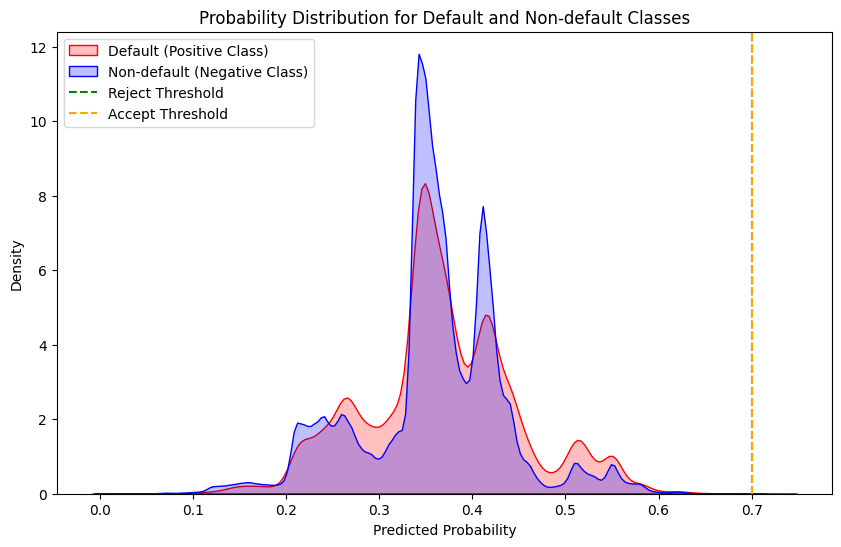

In [13]:
plot_probability_distribution(df_sp['fo_par90_flag'], df_sp['sp_f_pd'], 0.7, 0.7)

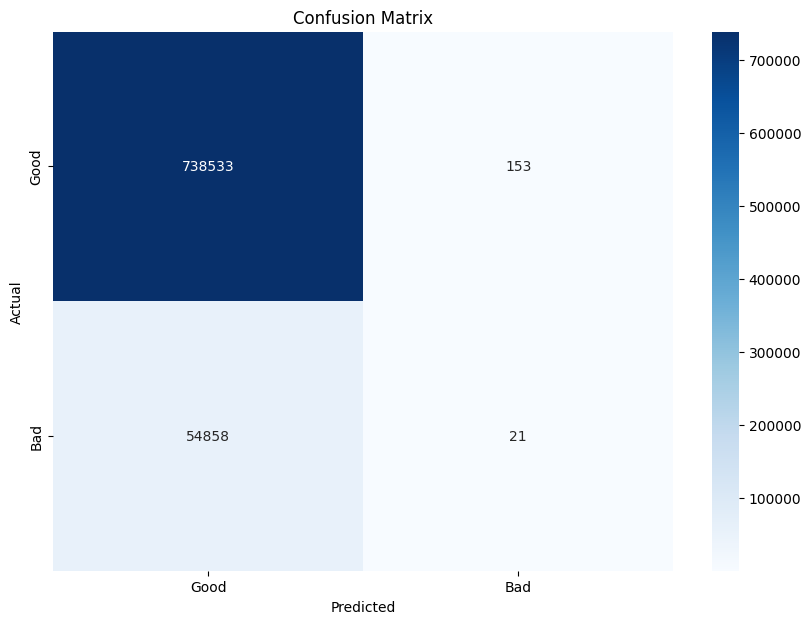

Precision: 12.07%
Recall: 0.04%
Approval rate: 99.98%


In [14]:
calc_class_metrics_iv(df_sp['fo_par90_flag'],
                        df_sp['sp_f_pd'],
                        score_cutoff=0.65,
                        normalize=False)

# 8- Exports

In [15]:
df_out = df_sp.rename({'sp_f_score': 'predics_score',
                       'sp_f_pd':'predics_pd'}, axis=1)
df_out = df_out[['client_id', 'predics_score', 'predics_pd']].reset_index(drop=True)

In [16]:
df_out.to_parquet(data_path+f'/models_preds/{data_date}_rule_based_v01_predics.parquet')